# Jupiter Notebook to build a quick and imperfect prediction solution

This notebook is an attempt to train a model to predict the salary in Data Science based on the kaggle dataset from https://www.kaggle.com/datasets/lainguyn123/data-science-salary-landscape.

In [86]:
# Package for linear regressions


import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score,root_mean_squared_log_error
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
sns.set_theme()
import warnings
warnings.filterwarnings('ignore')

## Loading and Cleaning datasets

In this section, we will load the dataset and extract the features and performs the cleaning.

In [87]:
pd.options.display.float_format = '{:.2f}'.format

salaries_dataset_url = './ds_salaries.csv'
full_dataset = pd.read_csv(salaries_dataset_url)
full_dataset.describe(include='all').T



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
work_year,3755.00,NaN,NaN,NaN,2022.37,0.69,2020.00,2022.00,2022.00,2023.00,2023.00
experience_level,3755,4,SE,2516,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment_type,3755,4,FT,3718,NaN,NaN,NaN,NaN,NaN,NaN,NaN
job_title,3755,93,Data Engineer,1040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salary,3755.00,NaN,NaN,NaN,190695.57,671676.50,6000.00,100000.00,138000.00,180000.00,30400000.00
salary_currency,3755,20,USD,3224,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salary_in_usd,3755.00,NaN,NaN,NaN,137570.39,63055.63,5132.00,95000.00,135000.00,175000.00,450000.00
employee_residence,3755,78,US,3004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
remote_ratio,3755.00,NaN,NaN,NaN,46.27,48.59,0.00,0.00,0.00,100.00,100.00
company_location,3755,72,US,3040,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 3678 entries, 0 to 3754
Columns: 182 entries, job_title to remote_ratio_str_50
dtypes: int64(182)
memory usage: 5.1 MB
<class 'pandas.core.series.Series'>
Index: 3678 entries, 0 to 3754
Series name: salary_in_usd
Non-Null Count  Dtype  
--------------  -----  
3678 non-null   float64
dtypes: float64(1)
memory usage: 57.5 KB
Features num= 182 Index(['job_title', 'remote_ratio', 'work_year_2021', 'work_year_2022',
       'work_year_2023', 'experience_level_EX', 'experience_level_MI',
       'experience_level_SE', 'employment_type_FL', 'employment_type_FT',
       ...
       'company_location_SK', 'company_location_TH', 'company_location_TR',
       'company_location_UA', 'company_location_US', 'company_location_VN',
       'company_size_M', 'company_size_S', 'remote_ratio_str_100',
       'remote_ratio_str_50'],
      dtype='object', length=182)


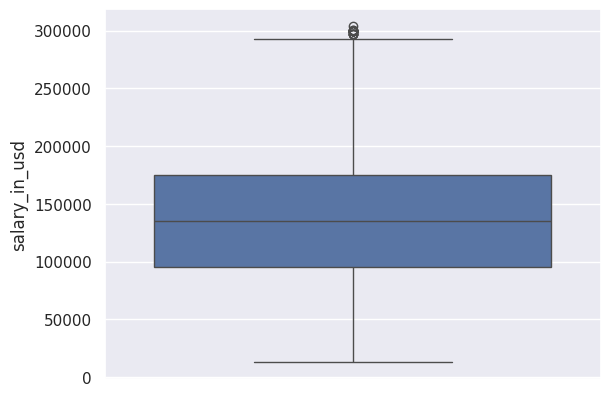

In [88]:

from sklearn import preprocessing


target_column = 'salary_in_usd'

#def my_preparation(X, Y):
# Reorder the salary column and remove the salary and currency columns and ID
ignored_cols =  ['salary']
X = full_dataset.drop(ignored_cols, axis=1)
#X.drop(X[X.company_location != "US"].index, inplace = True)
# We convert the work year as a categorical feature
label_encoder = preprocessing.LabelEncoder()   
# Encode labels in column 'species'. 
X['job_title']= label_encoder.fit_transform(X['job_title']) 
X['work_year'] = X['work_year'].map(str)
X['remote_ratio_str'] = X['remote_ratio'].map(str)

data_with_dummies = pd.get_dummies(X, drop_first=True)
data_preprocessed = data_with_dummies.replace({True:1, False:0})

q_low = data_preprocessed["salary_in_usd"].quantile(0.01)
q_hi  = data_preprocessed["salary_in_usd"].quantile(0.99)

data_preprocessed = data_preprocessed[(data_preprocessed["salary_in_usd"] < q_hi) & (data_preprocessed["salary_in_usd"] > q_low)]

sns.boxplot(data_preprocessed[target_column])



X = data_preprocessed
Y =  np.log(X[target_column])
X = X.drop(['salary_in_usd'], axis=1)


# We apply log on the salary feature
X.info()
Y.info()
feature_cols = X.columns

print("Features num=", len(feature_cols), feature_cols)
# Export CSV
X.to_csv('train.csv', index=False)  

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)


### Split the dataset in train and test



In [89]:
print("X_train", X_train.shape)
print("X_test", X_test.shape)
print("Y_train", y_train.shape)
print("Y_test", y_test.shape)

X_train (3310, 182)
X_test (368, 182)
Y_train (3310,)
Y_test (368,)


## Model training

We will use a hierarchical model to train.

In [125]:
from lightgbm import LGBMRegressor
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ARDRegression, BayesianRidge, HuberRegressor, Lars, LarsCV, Lasso, LassoCV, LogisticRegression, MultiTaskElasticNet, QuantileRegressor, RANSACRegressor, RidgeCV, SGDRegressor, TheilSenRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVR
import tensorflow as tf
from xgboost import XGBRegressor


def get_estimators(X, y):
    cat_selector = make_column_selector(dtype_include=object)
    num_selector = make_column_selector(dtype_include=np.number)
    cat_selector(X)


    cat_tree_processor = OrdinalEncoder(
        handle_unknown="use_encoded_value",
        unknown_value=-1,
        encoded_missing_value=-2,
    )
    num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

    cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
    num_linear_processor = make_pipeline(
        StandardScaler(), 
        SimpleImputer(strategy="mean", add_indicator=True)
    )

    linear_preprocessor = make_column_transformer(
        (num_linear_processor, num_selector), 
        (cat_linear_processor, cat_selector)
    )

    tree_preprocessor = make_column_transformer(
        (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
    )

    rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(random_state=42))
    
    knn_pipeline = make_pipeline(
        linear_preprocessor, KNeighborsRegressor(n_neighbors=10)
    )
    dt_params = {'max_depth': 100,'min_samples_split': 2, 'criterion': 'poisson'}
    estimators = [
        ("Random Forest", rf_pipeline),
        #("LassoCV", lasso_pipeline),
        #("Gradient Boosting", gbdt_pipeline),
        ("KNN", knn_pipeline),   
        #("DecisionTreeRegressor", make_pipeline(tree_preprocessor, DecisionTreeRegressor(**dt_params))),
        #("ARDRegression", make_pipeline(linear_preprocessor, ARDRegression())),   
        ("HuberRegressor", make_pipeline(linear_preprocessor, HuberRegressor())),   
        #("LarsCV", make_pipeline(linear_preprocessor, LarsCV())),   
        #("QuantileRegressor", make_pipeline(linear_preprocessor, QuantileRegressor())),
        #("Bayesian", make_pipeline(linear_preprocessor, BayesianRidge())),
        ("LR", make_pipeline(linear_preprocessor, LinearRegression(positive=True))),   
        ("XGB", make_pipeline(linear_preprocessor, XGBRegressor())),   
        #("LGBM", make_pipeline(linear_preprocessor, LGBMRegressor(learning_rate=0.1))),   
        #("SVR", make_pipeline(linear_preprocessor, SVR())),   
        #('Ridge', make_pipeline(linear_preprocessor, Ridge(alpha=10))),
        #('ENet', make_pipeline(linear_preprocessor, ElasticNet(alpha=0.006974)))
    ]
    return estimators


estimators = get_estimators( X_train, y_train )

def predict_and_evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)

    #print("Predictions: ", y_pred[y_pred < 0])
    #print("Predictions2: ", y_test)
    #print(y_pred[0:5])
    #print(y_test[0:5])

    ## Compute Accuracy

    print("mean_squared_log_error (MSLE): %.2f" % mean_squared_log_error(y_test, y_pred))  
    print("root_mean_squared_log_error: %.2f" % root_mean_squared_log_error(y_test, y_pred))
    print("Coefficient of determination, R2: %.2f" % r2_score(y_test, y_pred))


for name, model in estimators:
    print(f"{name}: ")
    model.fit(X_train, y_train)         
    predict_and_evaluate(model, X_test, y_test)

print("--------------------------------")
print("Stacking regressor") 
regr = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
regr.fit(X_train, y_train)
predict_and_evaluate(regr, X_test, y_test)


Random Forest: 
mean_squared_log_error (MSLE): 0.00
root_mean_squared_log_error: 0.03
Coefficient of determination, R2: 0.55
KNN: 
mean_squared_log_error (MSLE): 0.00
root_mean_squared_log_error: 0.03
Coefficient of determination, R2: 0.43
HuberRegressor: 
mean_squared_log_error (MSLE): 0.00
root_mean_squared_log_error: 0.03
Coefficient of determination, R2: 0.52
LR: 
mean_squared_log_error (MSLE): 0.00
root_mean_squared_log_error: 0.03
Coefficient of determination, R2: 0.50
XGB: 
mean_squared_log_error (MSLE): 0.00
root_mean_squared_log_error: 0.03
Coefficient of determination, R2: 0.58
--------------------------------
Stacking regressor
mean_squared_log_error (MSLE): 0.00
root_mean_squared_log_error: 0.03
Coefficient of determination, R2: 0.58


### Graph and precision evaluation

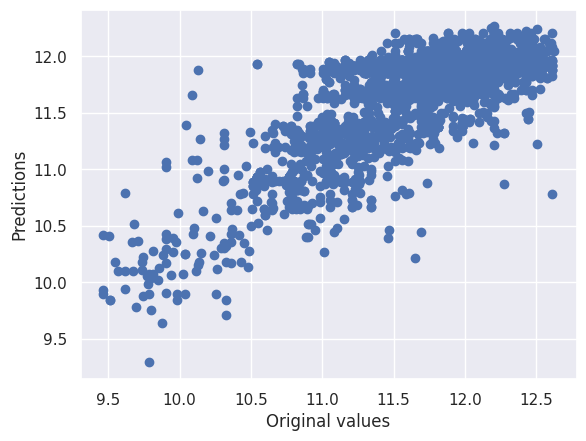

In [126]:
reg=LinearRegression(positive=True)
reg.fit(X_train, y_train)
yhat = reg.predict(X_train)
plt.scatter(y_train, yhat)
plt.xlabel('Original values')
plt.ylabel('Predictions')
plt.show()


In [128]:
linear_predictions = reg.predict(X_test)
our_mode_predictions = regr.predict(X_test)


print("root_mean_squared_log_error: LinearR %.2f" % root_mean_squared_log_error(y_test, linear_predictions))
print("root_mean_squared_log_error : our Model: %.2f" % root_mean_squared_log_error(y_test, our_mode_predictions))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination, LinearR, R2: %.2f" % r2_score(y_test, linear_predictions))
print("Coefficient of determination complex, our Model, R2: %.2f" % r2_score(y_test, our_mode_predictions))



results = pd.DataFrame({'Prediction': np.exp(linear_predictions), 'Actual': np.exp(y_test)})
results["Prediction my model"] = np.exp(our_mode_predictions)
results['Difference'] = np.exp(y_test) - np.exp(linear_predictions)
results['Difference %'] = abs(results['Difference'])/results['Actual']
results['Difference2'] = np.exp(y_test) - np.exp(our_mode_predictions)
results['Difference2 %'] = abs(results['Difference2'])/results['Actual']

results.sort_values(by='Difference %')

root_mean_squared_log_error: LinearR 0.03
root_mean_squared_log_error : our Model: 0.03
Coefficient of determination, LinearR, R2: 0.50
Coefficient of determination complex, our Model, R2: 0.58


,Prediction,Actual,Prediction my model,Difference,Difference %,Difference2,Difference2 %
3427,75000.00,75000.00,77406.16,0.00,0.00,-2406.16,0.03
829,145026.92,145000.00,127682.59,-26.92,0.00,17317.41,0.12
2937,112967.62,113000.00,101121.25,32.38,0.00,11878.75,0.11
702,136366.71,136000.00,163281.79,-366.71,0.00,-27281.79,0.20
295,136366.71,136000.00,163281.79,-366.71,0.00,-27281.79,0.20
...,...,...,...,...,...,...,...
2627,143759.91,50000.00,146365.13,-93759.91,1.88,-96365.13,1.93
3492,61670.17,20000.00,41220.50,-41670.17,2.08,-21220.50,1.06
2121,50363.50,13000.00,45843.28,-37363.50,2.87,-32843.28,2.53
2605,151237.39,38000.00,151803.42,-113237.39,2.98,-113803.42,2.99


## Export the model


We are going to save the model using joblib.